In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from xgboost import XGBClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [11]:
DATA_PATH = "../Dataset/US_Videos_Dataset.csv"
df = pd.read_csv(DATA_PATH, dtype={'trending_date': str})

cols = ["title", "tags", "publishedAt", "categoryId", "is_trending"]
df = df[cols].copy()
df = df.dropna(subset=["is_trending"])
df["title"] = df["title"].fillna("")
df["tags"] = df["tags"].fillna("")

df["publishedAt"] = pd.to_datetime(df["publishedAt"], errors="coerce")
df["pub_month"] = df["publishedAt"].dt.month.fillna(0).astype(int)
df["pub_dayofweek"] = df["publishedAt"].dt.dayofweek.fillna(0).astype(int)
df["pub_hour"] = df["publishedAt"].dt.hour.fillna(0).astype(int)


df["title_len"] = df["title"].apply(lambda x: len(str(x).split()))

def get_caps_ratio(text):
    text = str(text)
    if len(text) == 0: return 0
    return sum(1 for c in text if c.isupper()) / len(text)

df["caps_ratio"] = df["title"].apply(get_caps_ratio)

df["has_punct"] = df["title"].apply(lambda x: 1 if "!" in str(x) or "?" in str(x) else 0)


df["text"] = (df["title"].astype(str) + " " + df["tags"].astype(str)).str.lower()
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words="english")
X_text = tfidf.fit_transform(df["text"])

time_feats = df[["pub_month","pub_dayofweek","pub_hour"]].astype(float)

cat = df[["categoryId"]].fillna(0).astype(float)

extra_feats = df[["title_len", "caps_ratio", "has_punct"]].astype(float)

X = hstack([X_text, time_feats.values, cat.values, extra_feats.values])
y = df["is_trending"].astype(int).values

print("Data Shape with New Features:", X.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Data Shape with New Features: (395915, 5007)


In [12]:
from IPython.display import display

print("\n=== Sample of New Features ===")
cols_to_show = ['title', 'title_len', 'caps_ratio', 'has_punct', 'is_trending']

display(df[cols_to_show].head(5))


=== Sample of New Features ===


,title,title_len,caps_ratio,has_punct,is_trending
0,college farewell video#trending #viralshorts,4,0.000000,0,1
1,Busking in Manchester 🇬🇧 #blindfaith #guitar #...,12,0.021053,0,1
2,This is what happens when you play Star Wars i...,12,0.066667,0,1
3,LISA - FUTW (YouTube Music Nights Special Stag...,9,0.250000,0,1
4,Uljhi hai yeh kis jaal me tu…. Bengaluru ❤️,9,0.046512,0,1


In [13]:
DATA_PATH = "../Dataset/US_Videos_Dataset.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
df.head()

C:\Users\emada\AppData\Local\Temp\ipykernel_27828\2515914951.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


Shape: (395915, 15)


,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,comment_count,thumbnail_link,comments_disabled,description,is_trending
0,G4M_621v1As,college farewell video#trending #viralshorts,2025-04-12T02:06:42Z,UC7k_7IF3s3TY-cowwxs_yWw,Vk_07_rider,22.0,2025-11-08,"college farewell video, DDU farewell video, fa...",125784084.0,1557178.0,1583.0,https://i.ytimg.com/vi/G4M_621v1As/default.jpg,0,DDU farewell party video \n college farewell v...,1
1,z2voqo_Jhx4,Busking in Manchester 🇬🇧 #blindfaith #guitar #...,2025-04-06T11:35:53Z,UCM_9JHB3xXPSzJfTkD86AtA,Leonardo Patrick,10.0,2025-11-08,NaN,94744011.0,925529.0,5849.0,https://i.ytimg.com/vi/z2voqo_Jhx4/default.jpg,0,NaN,1
2,jHIt9oHFLsw,This is what happens when you play Star Wars i...,2025-04-06T10:07:12Z,UC4YyKY5o60Kckk-GXOnhT2g,Violin Phonix,22.0,2025-11-08,NaN,61945818.0,1067412.0,4124.0,https://i.ytimg.com/vi/jHIt9oHFLsw/default.jpg,0,Full video : https://www.youtube.com/watch?v=Q...,1
3,gwRqLbWqKlM,LISA - FUTW (YouTube Music Nights Special Stag...,2025-03-19T03:29:33Z,UC6-BgjsBa5R3PZQ_kZ8hKPg,LLOUD Official,10.0,2025-11-08,"Blackpink, Lisa, Music, Fashion, K-Pop, kpop, ...",14555963.0,455816.0,20396.0,https://i.ytimg.com/vi/gwRqLbWqKlM/default.jpg,0,"LISA’s debut album, ‘Alter Ego’ is out now. Li...",1
4,prpRoyrutcE,Uljhi hai yeh kis jaal me tu…. Bengaluru ❤️,2025-04-14T10:17:58Z,UCiFXnvi8ESDukE25ol2foWQ,Mr.KiranJ,10.0,2025-11-08,NaN,26204942.0,336267.0,2333.0,https://i.ytimg.com/vi/prpRoyrutcE/default.jpg,0,NaN,1


Training XGBoost...

=== XGBoost Performance (Real World) ===
Accuracy : 0.8877
ROC-AUC  : 0.9531


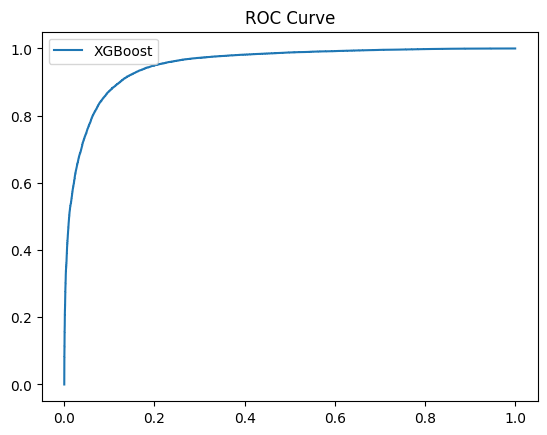

In [14]:
print("Training XGBoost...")
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("\n=== XGBoost Performance (Real World) ===")
print(f"Accuracy : {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"ROC-AUC  : {roc_auc_score(y_test, y_prob_xgb):.4f}")

fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)
plt.plot(fpr, tpr, label="XGBoost")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [15]:
X_train_dense = torch.tensor(X_train.toarray(), dtype=torch.float32)
X_test_dense  = torch.tensor(X_test.toarray(),  dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32)

train_ds = TensorDataset(X_train_dense, y_train_t)
test_ds  = TensorDataset(X_test_dense,  y_test_t)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=512, shuffle=False)

In [16]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(1)

model = MLP(input_dim=X_train_dense.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
print("Training MLP...")
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

model.eval()
with torch.no_grad():
    logits = model(X_test_dense.to(device))
    probs_mlp = torch.sigmoid(logits).cpu().numpy()
    preds_mlp = (probs_mlp >= 0.5).astype(int)

print("\n=== MLP Performance (Real World) ===")
print(f"Accuracy : {accuracy_score(y_test, preds_mlp):.4f}")
print(f"ROC-AUC  : {roc_auc_score(y_test, probs_mlp):.4f}")

Training MLP...
Epoch 1/10, Loss: 0.2958
Epoch 2/10, Loss: 0.2261
Epoch 3/10, Loss: 0.1981
Epoch 4/10, Loss: 0.1772
Epoch 5/10, Loss: 0.1660
Epoch 6/10, Loss: 0.1527
Epoch 7/10, Loss: 0.1429
Epoch 8/10, Loss: 0.1338
Epoch 9/10, Loss: 0.1284
Epoch 10/10, Loss: 0.1221

=== MLP Performance (Real World) ===
Accuracy : 0.9476
ROC-AUC  : 0.9836


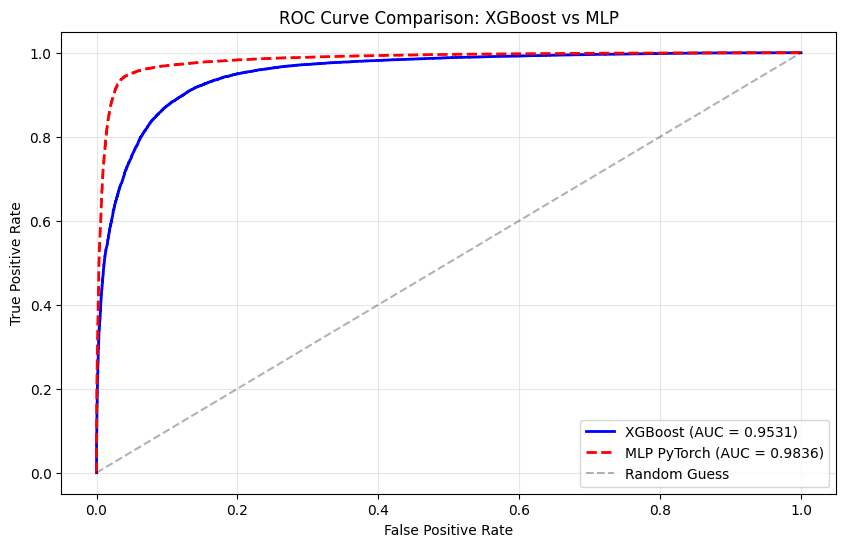

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)

model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32).to(device)
    logits = model(X_test_tensor)
    y_prob_mlp = torch.sigmoid(logits).cpu().numpy()

fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_prob_mlp)
auc_mlp = roc_auc_score(y_test, y_prob_mlp)

plt.figure(figsize=(10, 6))

plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.4f})", color='blue', linewidth=2)

plt.plot(fpr_mlp, tpr_mlp, label=f"MLP PyTorch (AUC = {auc_mlp:.4f})", color='red', linestyle='--', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.3, label="Random Guess")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: XGBoost vs MLP')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

In [18]:

def predict_trend_xgb(title, tags, published_at, category_id=10):

    text = (str(title) + " " + str(tags)).lower()
    x_txt = tfidf.transform([text])

    dt = pd.to_datetime(published_at)
    x_time = np.array([[dt.month, dt.dayofweek, dt.hour]])

    x_cat = np.array([[float(category_id)]])

    t_len = len(str(title).split())
    t_caps = sum(1 for c in str(title) if c.isupper()) / len(str(title)) if len(str(title)) > 0 else 0
    t_punct = 1 if "!" in str(title) or "?" in str(title) else 0

    x_extra = np.array([[t_len, t_caps, t_punct]])
    x_final = hstack([x_txt, x_time, x_cat, x_extra])
    prob = xgb_model.predict_proba(x_final)[:, 1][0]
    return prob

def predict_trend_mlp(title, tags, published_at, category_id=10):
    model.eval()

    text = (str(title) + " " + str(tags)).lower()
    x_txt = tfidf.transform([text])

    dt = pd.to_datetime(published_at)
    x_time = np.array([[dt.month, dt.dayofweek, dt.hour]])

    x_cat = np.array([[float(category_id)]])

    t_len = len(str(title).split())
    t_caps = sum(1 for c in str(title) if c.isupper()) / len(str(title)) if len(str(title)) > 0 else 0
    t_punct = 1 if "!" in str(title) or "?" in str(title) else 0
    x_extra = np.array([[t_len, t_caps, t_punct]])

    x_final = hstack([x_txt, x_time, x_cat, x_extra]).toarray()
    x_tensor = torch.tensor(x_final, dtype=torch.float32).to(device)

    with torch.no_grad():
        logit = model(x_tensor).item()
        prob = 1 / (1 + np.exp(-logit))
    return prob

sample_title = "Official Trailer: GTA VI (Grand Theft Auto 6)"
sample_tags = "game trailer official rockstar games"
sample_date = "2025-10-01 18:00"
sample_cat = 10 # 28 = Science & Technology

p_xgb = predict_trend_xgb(sample_title, sample_tags, sample_date, sample_cat)
p_mlp = predict_trend_mlp(sample_title, sample_tags, sample_date, sample_cat)

print(f"\nPrediction for Clickbait Title: '{sample_title}'")
print(f"XGBoost Probability: {p_xgb:.2%}")
print(f"MLP Probability    : {p_mlp:.2%}")


Prediction for Clickbait Title: 'Official Trailer: GTA VI (Grand Theft Auto 6)'
XGBoost Probability: 94.99%
MLP Probability    : 99.43%


In [19]:
viral_title = "Breaking: Apple unveils iPhone 17 with revolutionary AI features"
viral_tags = "apple iphone ai launch technology"
viral_date = "2025-09-15 22:00"

viral_category = 28

p_xgb = predict_trend_xgb(viral_title, viral_tags, viral_date, viral_category)
p_mlp = predict_trend_mlp(viral_title, viral_tags, viral_date, viral_category)

print(f"\nPrediction for '{viral_title}' (Category 28):")
print(f"XGBoost Probability: {p_xgb:.2%}")
print(f"MLP Probability    : {p_mlp:.2%}")


Prediction for 'Breaking: Apple unveils iPhone 17 with revolutionary AI features' (Category 28):
XGBoost Probability: 11.15%
MLP Probability    : 11.27%


In [20]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("Fast Mode is starting to create the table...")



print("1. Fast XGBoost training...")

xgb_fast = XGBClassifier(n_estimators=10, max_depth=3, n_jobs=-1, random_state=42)
xgb_fast.fit(X_train, y_train)

# التوقع
y_pred_xgb = xgb_fast.predict(X_test)
y_prob_xgb = xgb_fast.predict_proba(X_test)[:, 1]


print("2. Fast MLP training...")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_t = torch.tensor(X_train.toarray(), dtype=torch.float32)
X_test_t = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)


class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(1)

model = MLP(input_dim=X_train.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()


dataset = TensorDataset(X_train_t, y_train_t)
loader = DataLoader(dataset, batch_size=512, shuffle=True)

model.train()
for xb, yb in loader:
    xb, yb = xb.to(device), yb.to(device)
    optimizer.zero_grad()
    loss = criterion(model(xb), yb)
    loss.backward()
    optimizer.step()

# التوقع
model.eval()
with torch.no_grad():
    logits = model(X_test_t.to(device))
    probs_mlp = torch.sigmoid(logits).cpu().numpy()
    preds_mlp = (probs_mlp >= 0.5).astype(int)


print("\nCalculation completed! Rendering the table...")

results_list = []
def add_row(model_name, y_true, y_p, y_prob):
    results_list.append({
        "Name": "Emad Alkasabli",
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_p),
        "Precision": precision_score(y_true, y_p),
        "Recall": recall_score(y_true, y_p),
        "F1-Score": f1_score(y_true, y_p),
        "ROC-AUC": roc_auc_score(y_true, y_prob)
    })

add_row("XGBoost", y_test, y_pred_xgb, y_prob_xgb)
add_row("MLP (PyTorch)", y_test, preds_mlp, probs_mlp)


final_df = pd.DataFrame(results_list)
print("\n=== Modellerin Karşılaştırılması (Comparison Table) ===")
display(final_df.round(4))

Fast Mode is starting to create the table...
1. Fast XGBoost training...
2. Fast MLP training...

Calculation completed! Rendering the table...

=== Modellerin Karşılaştırılması (Comparison Table) ===


,Name,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Emad Alkasabli,XGBoost,0.7923,0.7754,0.7555,0.7653,0.8696
1,Emad Alkasabli,MLP (PyTorch),0.8915,0.9336,0.8161,0.8709,0.9620
